In [2]:
!pip install --quiet --upgrade comet_ml
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="0EKSrlH9OVngYfgQCrauwqLEt",
                        project_name="mri-interpretation", workspace="polina")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/polina/mri-interpretation/60f7e83759434c7c842396370af5ae89



In [3]:
# !pip install torchio

In [4]:
import numpy as np
import functools
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
# from torchsummary import summary
import os
import pathlib
from sklearn.model_selection import train_test_split, StratifiedKFold
import torchio
import nibabel as nib
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import *
import random
from sklearn.metrics import roc_auc_score, precision_score, recall_score
%matplotlib inline

In [5]:
import nilearn
from nilearn import plotting

In [6]:
from data_for_mask import HCP_MRI_reshape
# from data import HCP_MRI_crop

In [7]:
 torch.cuda.is_available()

True

In [8]:
if torch.cuda.is_available():
  device = torch.device("cuda:1")
else:
  device = torch.device("cpu")

In [10]:
! nvidia-smi

Sun Apr  4 14:31:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:05:00.0 Off |                    0 |
| N/A   39C    P0    34W / 250W |  11915MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:08:00.0 Off |                    0 |
| N/A   34C    P0    35W / 250W |    729MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Data

In [11]:
data_dir = pathlib.Path('/data/adni')

In [12]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
# plot_central_cuts(nilearn.image.get_data(img)[np.newaxis,:], title="ex", t = None)
# plot_central_cuts(img_crop, title="ex", t = None)

In [13]:
# PATH_TO_MRI = '/data/hcp/HCP_T1_pm'
PATH_TO_MRI = '/home/crop_data_resize'
data_dir = pathlib.Path('/data/adni')
behavioral_path = os.path.join('/data/adni', 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'

In [14]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

HCP absmax before normalization: 435.0126647949219
Train Dataset size: 889
Test Dataset size: 223
Labels distribution: (array([0, 1]), array([482, 407]))

Train example:


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


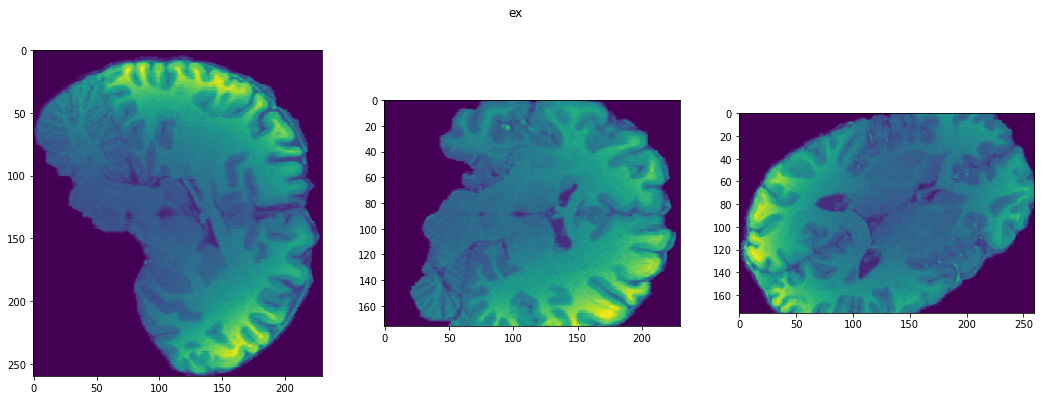

Val example:
Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


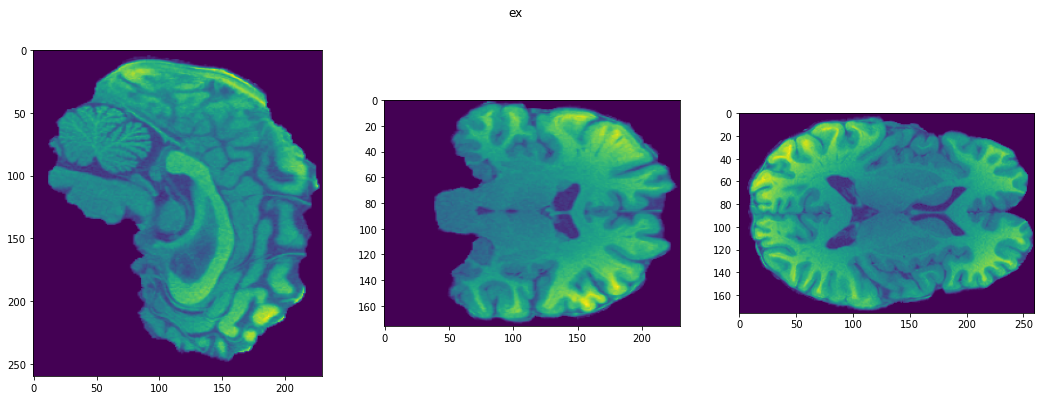

In [15]:
X_train, X_test = train_test_split(pd.read_csv(behavioral_path), test_size=0.2, random_state=42) 
train_hcp_dataset = HCP_MRI_reshape(
    paths= PATH_TO_MRI,
    target_path= X_train,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40, 40, 30, 30, 45, 45), #40,25,55,( 15, 15, 0, 19, 34, 51)
    img_shape=(176, 260, 230) #176, 260, 230, (226, 301, 235), 256, 320, 320
)
val_hcp_dataset = HCP_MRI_reshape(
    paths= PATH_TO_MRI,
    target_path= X_test,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40, 40, 30, 30, 45, 45), #40,25,55
    img_shape=(176, 260, 230) #176, 260, 230, 226, 301, 235), 256, 320, 320
)

hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
train_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
val_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
train_transform = Compose([
    ToTensor(),
#     BrightnessContrast(),
#     GaussNoise(),
    RandomRotation(degrees = 35),
    RandomAffine(degrees = 0, scale=(0.8, 1.1)) #0.8,1.2
#     ToTensor(),
])

val_transform = Compose([
#     BrightnessContrast(),
#     GaussNoise(),
#     Rotate(),
    ToTensor(),
])
# train_transform = torchio.transforms.Compose([
# #     BrightnessContrast(),
# #     GaussNoise(),
#     torchio.transforms.RandomAffine(scales=(0.8, 1.2), degrees = 10),
# #     ToTensor(),
# ])

train_hcp_dataset.transform = train_transform
val_hcp_dataset.transform = val_transform
print("HCP absmax before normalization: {}".format(hcp_absmax))
print("Train Dataset size: {}".format(len(train_hcp_dataset)))
print("Test Dataset size: {}".format(len(val_hcp_dataset)))
print("Labels distribution: {}\n".format(np.unique(train_hcp_dataset.labels, return_counts=True)))

print("Train example:")
img, target = train_hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)
print("Val example:")
img, target = val_hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)

In [ ]:
# import time 
# start_time = time.time()
# img = np.load('/home/crop_data_resize/167743_3T_T1w_MPR1_bet_mask_crop.npy') 
# print( time.time() - start_time)

In [ ]:
# import time 
# start_time = time.time()
# img = nib.load('/home/crop_data_resize/167743_3T_T1w_MPR1_bet_mask_crop.nii.gz').get_data() 
# print( time.time() - start_time)

In [ ]:
# !rm -r crop_data

In [ ]:
# from skimage.transform import resize
# from skimage import util
# from tqdm import tqdm
# PATH_TO_MRI = '/data/hcp/HCP_T1_pm'
# mri_paths = {
#             "participant_id": [],
#             "path": []
#         }
# bd = pd.read_csv(behavioral_path)
# bd.set_index('Subject',inplace=True)
# y_gender = []
        
# for patient_folder_name in os.listdir(PATH_TO_MRI):
#     if 'nii' in patient_folder_name:
#             sub = patient_folder_name[:6]
#             if int(sub) in bd.index.values:
#                 full_path = '{}/{}_3T_T1w_MPR1_bet_mask.nii.gz'.format(PATH_TO_MRI, sub)
#                 if os.path.exists(full_path):
#                     mri_paths["participant_id"].append(sub)
#                     mri_paths["path"].append(full_path)
#                     y_gender.append(bd['Gender'][int(sub)])

# mri_paths = pd.DataFrame(mri_paths)
    
# mri_paths['Gender'] = y_gender
# #         print(self.mri_paths['Gender'])
# mri_paths = mri_paths["path"].tolist()
# for nii_path in tqdm(mri_paths):
#             img = nib.load(nii_path).get_data()
#             subj_bool = img != 0
#     #         subj_bool = subj_bool.reshape( (256, 320, 320,1))
#             ax_zero_cut = torch.from_numpy(subj_bool).max(dim=2).values.max(dim=1).values.data.numpy()
#             ax_one_cut = torch.from_numpy(subj_bool).max(dim=2).values.max(dim=0).values.data.numpy()
#             ax_two_cut = torch.from_numpy(subj_bool).max(dim=1).values.max(dim=0).values.data.numpy()
#             ax_zero_min, ax_zero_max = np.where(ax_zero_cut)[0][[0, -1]]
#             ax_one_min, ax_one_max = np.where(ax_one_cut)[0][[0, -1]]
#             ax_two_min, ax_two_max = np.where(ax_two_cut)[0][[0, -1]]
# #             print(img.dtype)
#             img = img[
#                       ax_zero_min:ax_zero_max + 1,
#                       ax_one_min:ax_one_max + 1,
#                       ax_two_min:ax_two_max + 1,
#                       ]
# #             print(img.dtype)
            
# #             plot_central_cuts(img[None,:,:,:], title="ex", t = None)
#             img = util.img_as_int(resize(img, (176, 260, 230)))
            
#             np.save('/home/crop_data_resize_np/{}_3T_T1w_MPR1_bet_mask_crop'.format(nii_path[-34:-28]), img) #-39, -33
#             nib.save(nib.Nifti1Image(img, affine = np.eye(4)), '/home/crop_data_resize/{}_3T_T1w_MPR1_bet_mask_crop.nii.gz'.format(nii_path[-34:-28]))

In [ ]:
# !df -h

In [ ]:
# !du

In [ ]:
# !rm -r ./.Trash-0/info/*

In [14]:
train_loader = torch_data.DataLoader(train_hcp_dataset,
                                          shuffle=True,
                                          batch_size=4)
val_loader = torch_data.DataLoader(val_hcp_dataset,
                                    shuffle=False,
                                    batch_size=2)

# Model structure

In [18]:
# timing
from tqdm import tqdm

def get_metric(net, data_loader):
    net.eval()
    correct = 0
    true = []
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        true.append(pred.data.cpu().numpy())
        correct += pred.eq(target.data).cpu().sum()
        del data, target, out, pred
    accuracy = 100. * correct / len(data_loader.dataset)
    true = np.concatenate(true)
    roc_auc = roc_auc_score(data_loader.dataset.labels, true)
    pr = precision_score(data_loader.dataset.labels,  true)
    rec = recall_score(data_loader.dataset.labels, true)

    return accuracy.item(), roc_auc, pr, rec

def get_loss(net, data_loader):
    net.eval()
    loss = 0 
    correct = 0
    for data, target in tqdm(data_loader):
        data = data.to(device, dtype=torch.float)
        target = target.to(device)
    
        out = net(data)
        loss += criterion(out, target).item()*len(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

        del data, target, out 
    accuracy = 100. * correct / len(data_loader.dataset)
    return loss / len(data_loader.dataset), accuracy.item()


def train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save=False, experiment= False):
    best_val_loss = 100000 #100_000
    best_val_acc = 0
    best_model = None
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    loss, acc = get_loss(net, train_loader)
    train_loss_list.append(loss)
    train_acc_list.append(acc)
    loss, acc = get_loss(net, val_loader)
    val_loss_list.append(loss)
    val_acc_list.append(acc)
    del loss, acc
    if verbose:
        print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(0, epochs, train_loss_list[-1], val_loss_list[-1]))

    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        train_loss = 0
        train_correct = 0
        for X, y in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X, y = X.to(device, dtype=torch.float), y.to(device)
            optimizer.zero_grad()
#             print(type(X))
            out = net(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(X)
            pred = out.data.max(1)[1] # get the index of the max log-probability
            train_correct += pred.eq(y.data).cpu().sum()
            del X, y, out, loss #freeing gpu space
        accuracy = 100. * train_correct / len(train_loader.dataset)
        train_loss_list.append(train_loss/len(train_loader.dataset))
        train_acc_list.append(accuracy.item())
            
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        loss, acc = get_loss(net, val_loader)
        val_loss_list.append(loss)
        val_acc_list.append(acc)
        
        if scheduler is not None:
            scheduler.step(val_acc_list[-1])

        if save and val_acc_list[-1] > best_val_acc:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_acc_model_' + model_name)    
            best_val_acc = val_acc_list[-1]
            
        if save and val_loss_list[-1] < best_val_loss:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_val_loss_model_' + model_name)
            best_val_loss = val_loss_list[-1]
            
        if save and epoch%5==0:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + str(epoch) + '_epoch_model_' + model_name)
            
        freq = 1
        if verbose and epoch%freq==0:
            print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f} Acc: Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_loss_list[-1], val_loss_list[-1], train_acc_list[-1], val_acc_list[-1] ))
        if experiment:
                experiment.log_metric("train_loss", train_loss_list[-1])
                experiment.log_metric("validate_loss", val_loss_list[-1])
                experiment.log_metric("train_acc", train_acc_list[-1])
                experiment.log_metric("validate_acc", val_acc_list[-1])
                experiment.log_epoch_end(epoch)
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list    

In [19]:
torch.cuda.empty_cache()

In [20]:
CHECKPOINTS_DIR =  '/home/checkpoints_for_mask_cv/'

In [21]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2,),
                
                nn.Conv3d(c, 2*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1896960, out_features=2), #4*c*5*7*5
        )
        self.gradients = None
        
     
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [22]:
if torch.cuda.device_count() > 1:
      d_ids= [1,6,5,4]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

model.to(device)

Let's use [1, 6, 5, 4] GPUs!


DataParallel(
  (module): MriNetGrad(
    (features): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
    (classifier): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_feat

In [21]:
# criterion = nn.NLLLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #return ADAM?
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
criterion = nn.CrossEntropyLoss()


In [22]:
model_name = '_checkpoints_for_mask_cv'
experiment.set_name("3DCNN_checkpoints_for_mask_cv")

In [ ]:
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 60

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 

In [ ]:
!cd /home/checkpoints_torchion_reshape && ls

In [ ]:
model.load_state_dict(torch.load('/home/checkpoints_torchion_reshape/best_acc_model__checkpoints_torchio_reshape'))
model.eval()

In [ ]:
get_metric(model, val_loader)

In [ ]:
get_metric(model, train_loader)

In [ ]:
!jupyter notebook list

In [23]:
CHECKPOINTS_DIR =  '/home/checkpoints_for_mask_cv/'

In [24]:
def get_accuracy(net, data_loader):
    net.eval()
    correct = 0
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        del data, target
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy.item()

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_vall_acc_list = []
j = 0
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
for X_train, X_test in skf.split(pd.read_csv(behavioral_path),pd.read_csv(behavioral_path).Gender):
    print('Doing {} split'.format(j))
    j += 1
    train_hcp_dataset = HCP_MRI_reshape(
    paths= PATH_TO_MRI,
    target_path= pd.read_csv(behavioral_path).iloc[X_train],
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40,25,55),
    img_shape=(176, 260, 230)
    )
    val_hcp_dataset = HCP_MRI_reshape(
        paths= PATH_TO_MRI,
        target_path= pd.read_csv(behavioral_path).iloc[X_test],
        load_online=True,
        hcp_type = hcp_type,
        coord_min=(40, 40, 30, 30, 45, 45),
        img_shape=(176, 260, 230)
    )
    hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
    train_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
    val_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
    train_transform = Compose([
        ToTensor(),
    #     BrightnessContrast(),
    #     GaussNoise(),
        RandomRotation(degrees = 35),
        RandomAffine(degrees = 0, scale=(0.8,1.2))
    #     ToTensor(),
    ])

    val_transform = Compose([
    #     BrightnessContrast(),
    #     GaussNoise(),
    #     Rotate(),
        ToTensor(),
    ])
    train_hcp_dataset.transform = train_transform
    val_hcp_dataset.transform = val_transform

    train_loader = torch_data.DataLoader(train_hcp_dataset,
                                          shuffle=True,
                                          batch_size=4)
    val_loader = torch_data.DataLoader(val_hcp_dataset,
                                    shuffle=False,
                                    batch_size=2)

#     model = mri_model.MriNet(C).to(device)
#     criterion = nn.NLLLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
#     scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
    c = 32
    model = MriNetGrad(c)
    if torch.cuda.device_count() > 1:
        d_ids= [1,6,5,4]
        print("Let's use", d_ids, "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model = nn.DataParallel(model, device_ids=d_ids)
        model.to(device)
    model_name = '_for_mask_cv_cv_{}'.format(j)
    experiment.set_name("Golden_3DCNN_checkpoints_for_mask_cv_cv_{}".format(j))
    
    torch.save(train_loader.dataset.mri_paths, CHECKPOINTS_DIR + 'train' +model_name)
    torch.save(val_loader.dataset.mri_paths, CHECKPOINTS_DIR + 'val' +model_name)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
    criterion = nn.CrossEntropyLoss()
    EPOCHS = 60

    train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 
#     _, _, _, _ = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, device, scheduler=scheduler, save=False, verbose=False) 
    cross_vall_acc_list.append(get_accuracy(model, val_loader, device))
    print(cross_vall_acc_list[-1])
print('Mean cross-validation accuracy (5-folds):', np.mean(cross_vall_acc_list))
print('Std cross-validation accuracy (5-folds):', np.std(cross_vall_acc_list, ddof=1))

Doing 0 split


  0%|          | 0/223 [00:00<?, ?it/s]

Let's use [1, 6, 5, 4] GPUs!


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")
